In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import Input

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
import pickle

import os
import cv2

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
train_data_dir = r'D:\data_projects\veggie_classification\train'
val_data_dir = r'D:\data_projects\veggie_classification\validation'
test_data_dir = r'D:\data_projects\veggie_classification\test'

In [6]:
batch_size = 64
img_size = 224

train_ds = image_dataset_from_directory(directory = train_data_dir, 
                                        labels = 'inferred', 
                                        label_mode = 'categorical',
                                        seed = 123,
                                        image_size = (img_size, img_size),
                                        batch_size = batch_size)


val_ds = image_dataset_from_directory(directory = val_data_dir, 
                                      labels = 'inferred', 
                                      label_mode = 'categorical',
                                      seed = 123,
                                      image_size = (img_size, img_size),
                                      batch_size = batch_size)


test_ds = image_dataset_from_directory(directory = test_data_dir, 
                                      labels = 'inferred', 
                                      label_mode = 'categorical',
                                      seed = 123,
                                      image_size = (img_size, img_size),
                                      batch_size = batch_size)

class_names = train_ds.class_names
print('\n', class_names)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.

 ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [7]:
def change_name(directory):
    for vegetable in class_names: # Needs to end with '/'
        path = directory + '/' +  vegetable + '/'
        for i, image in enumerate(os.listdir(path)):
            img = cv2.imread(path+str(image))
            if image.endswith(".jpeg") | image.endswith(".JPEG"):
                cv2.imwrite(path + vegetable + '_' + str(i) + str(image)[-5:], img)
            else:
                cv2.imwrite(path + vegetable + '_' + str(i) + str(image)[-4:], img)
            os.remove(path+image) # Remove that image

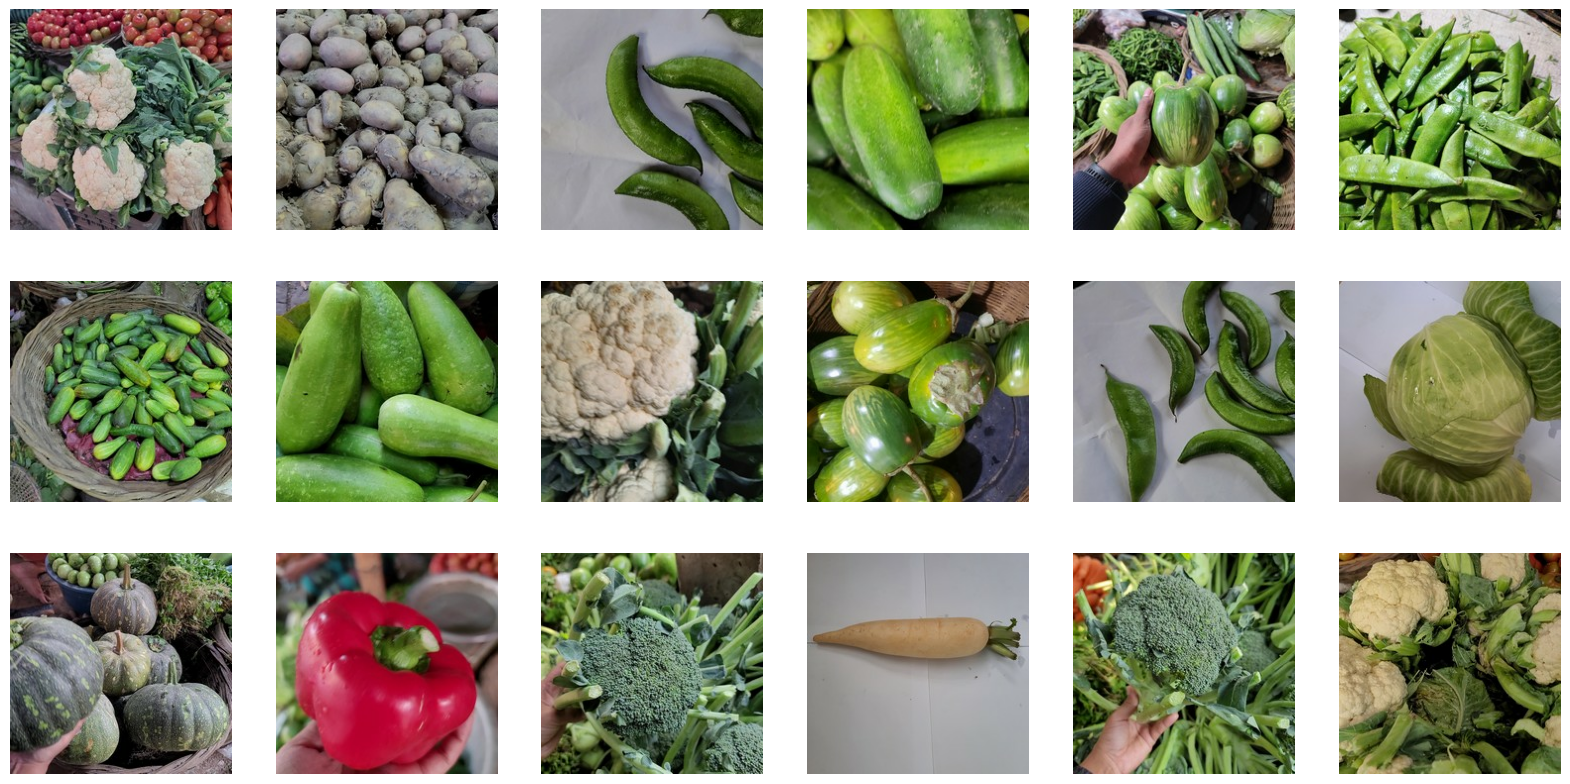

In [8]:
plt.figure(figsize=[20,10])
for image_batch, label_batch in val_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")

In [12]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3,  activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3,  activation='relu'),
    MaxPool2D(),  
    Flatten(),
    Dense(64, activation='relu'),
    Dense(15, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
reduce_lr = ReduceLROnPlateau(
    monitor='accuracy', factor=0.9, patience=3, verbose=0, mode='auto', min_delta=0.01)

early_stop = EarlyStopping(
    monitor='accuracy', min_delta=0.01, patience=3, verbose=0, mode='auto')

history = model.fit(train_ds, batch_size=64, epochs=50, validation_data=val_ds, callbacks=[reduce_lr,early_stop])

Epoch 1/50
235/235 [==============================] - 385s 2s/step - loss: 1.4950 - accuracy: 0.5236 - val_loss: 0.7407 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 305s 1s/step - loss: 0.4875 - accuracy: 0.8516 - val_loss: 0.4958 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 268s 1s/step - loss: 0.2506 - accuracy: 0.9255 - val_loss: 0.3239 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 226s 962ms/step - loss: 0.1393 - accuracy: 0.9599 - val_loss: 0.2820 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 256s 1s/step - loss: 0.0809 - accuracy: 0.9773 - val_loss: 0.2187 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - 234s 995ms/step - loss: 0.0496 - accuracy: 0.9856 - val_loss: 0.2297 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 242s

In [14]:
model.save("D:\\data_projects\\veggie_classification\\my_model")

INFO:tensorflow:Assets written to: D:\data_projects\veggie_classification\my_model\assets


INFO:tensorflow:Assets written to: D:\data_projects\veggie_classification\my_model\assets


In [35]:
with open("D:\\data_projects\\veggie_classification\\history_picle", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

In [49]:
with open("D:\\data_projects\\veggie_classification\\history_picle", "rb") as file_pi:
    history = pickle.load(file_pi)

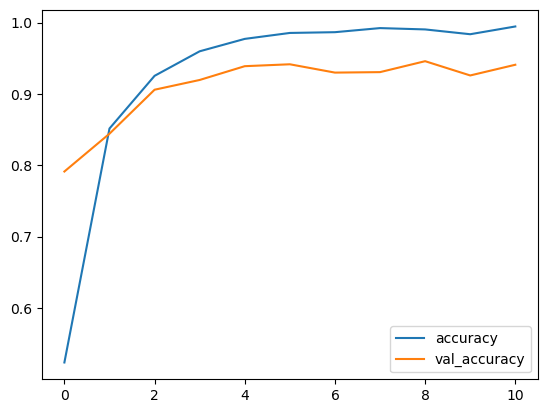

In [50]:
plt.plot(history['accuracy'], label = "accuracy")
plt.plot(history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

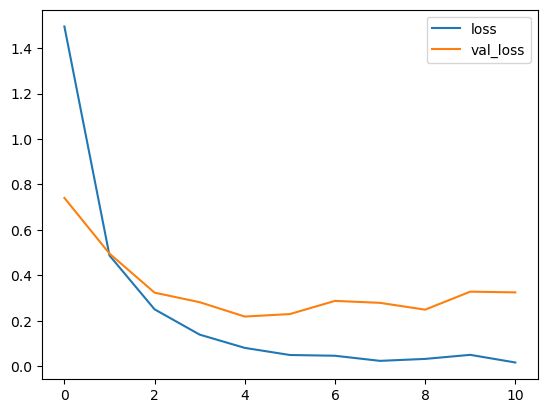

In [51]:
plt.plot(history['loss'], label = "loss")
plt.plot(history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

In [17]:
change_name(test_data_dir)

In [18]:
def image_to_array(file):
    img = tf.keras.preprocessing.image.load_img(file, target_size=(img_size, img_size, 3))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def get_predictions(model, directory):
    df = pd.DataFrame(columns=['File', 'prediction'])
    for veggie in class_names:
        for filename in os.listdir(directory + '/' + veggie):

            try:
                image=image_to_array(directory + '/' + veggie + '/' + filename)
                predictions = model.predict(image)
                score = tf.nn.softmax(predictions[0])
                df = pd.concat([df, pd.DataFrame({'File': [filename], 'prediction': [class_names[np.argmax(score)]]})], ignore_index=True)
                print(filename, 'prediction: ', class_names[np.argmax(score)])
            except:
                df = pd.concat([df, pd.DataFrame({'File': [filename], 'prediction': ["Not Possible"]})], ignore_index=True)

    df['Real_Category'] = df['File'].str.split('_').str[0]
    df['Predicted_Category'] = df['prediction']
    df['Result'] = np.where(df['Real_Category'].eq(df['Predicted_Category']), 'Correct Prediction', 'False Prediction')
    return df['Result'].value_counts()

In [19]:
model = keras.models.load_model("D:\\data_projects\\veggie_classification\\my_model")

In [20]:
original_results=get_predictions(model, test_data_dir)

1/1 [==============================] - 0s 373ms/step
Bean_0.jpg prediction:  Bean
1/1 [==============================] - 0s 41ms/step
Bean_1.jpg prediction:  Bean
1/1 [==============================] - 0s 43ms/step
Bean_10.jpg prediction:  Bean
1/1 [==============================] - 0s 23ms/step
Bean_100.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 31ms/step
Bean_101.jpg prediction:  Bean
1/1 [==============================] - 0s 39ms/step
Bean_102.jpg prediction:  Bean
1/1 [==============================] - 0s 40ms/step
Bean_103.jpg prediction:  Bean
1/1 [==============================] - 0s 42ms/step
Bean_104.jpg prediction:  Bean
1/1 [==============================] - 0s 40ms/step
Bean_105.jpg prediction:  Bean
1/1 [==============================] - 0s 40ms/step
Bean_106.jpg prediction:  Bean
1/1 [==============================] - 0s 41ms/step
Bean_107.jpg prediction:  Bean
1/1 [==============================] - 0s 40ms/step
Bean_108.jpg prediction:  Bean


1/1 [==============================] - 0s 41ms/step
Bean_97.jpg prediction:  Bean
1/1 [==============================] - 0s 43ms/step
Bean_98.jpg prediction:  Bean
1/1 [==============================] - 0s 43ms/step
Bean_99.jpg prediction:  Bean
1/1 [==============================] - 0s 45ms/step
Bitter_Gourd_0.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_1.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 43ms/step
Bitter_Gourd_10.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 43ms/step
Bitter_Gourd_100.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 45ms/step
Bitter_Gourd_101.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 43ms/step
Bitter_Gourd_102.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 45ms/step
Bitter_Gourd_103.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 23ms/step
Bitter_Gourd_1

Bitter_Gourd_170.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 41ms/step
Bitter_Gourd_171.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 41ms/step
Bitter_Gourd_172.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 41ms/step
Bitter_Gourd_173.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 39ms/step
Bitter_Gourd_174.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 22ms/step
Bitter_Gourd_175.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 40ms/step
Bitter_Gourd_176.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 40ms/step
Bitter_Gourd_177.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 43ms/step
Bitter_Gourd_178.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 42ms/step
Bitter_Gourd_179.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 41ms/step
Bitter_Gou

1/1 [==============================] - 0s 45ms/step
Bitter_Gourd_67.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 40ms/step
Bitter_Gourd_68.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_69.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 48ms/step
Bitter_Gourd_7.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 47ms/step
Bitter_Gourd_70.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_71.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_72.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_73.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 44ms/step
Bitter_Gourd_74.jpg prediction:  Bitter_Gourd
1/1 [==============================] - 0s 45ms/step
Bitter_Gourd_75.jpg prediction:  Bitter_Gourd
1/1 [================

1/1 [==============================] - 0s 42ms/step
Bottle_Gourd_36.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 45ms/step
Bottle_Gourd_37.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 38ms/step
Bottle_Gourd_38.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 40ms/step
Bottle_Gourd_39.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 40ms/step
Bottle_Gourd_4.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 39ms/step
Bottle_Gourd_40.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 26ms/step
Bottle_Gourd_41.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 34ms/step
Bottle_Gourd_42.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 29ms/step
Bottle_Gourd_43.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 34ms/step
Bottle_Gourd_44.jpg prediction:  Bottle_Gourd
1/1 [================

1/1 [==============================] - 0s 40ms/step
Brinjal_195.jpg prediction:  Brinjal
1/1 [==============================] - 0s 40ms/step
Brinjal_196.jpg prediction:  Brinjal
1/1 [==============================] - 0s 43ms/step
Brinjal_197.jpg prediction:  Brinjal
1/1 [==============================] - 0s 46ms/step
Brinjal_198.jpg prediction:  Brinjal
1/1 [==============================] - 0s 45ms/step
Brinjal_199.jpg prediction:  Brinjal
1/1 [==============================] - 0s 45ms/step
Brinjal_2.jpg prediction:  Brinjal
1/1 [==============================] - 0s 43ms/step
Brinjal_20.jpg prediction:  Brinjal
1/1 [==============================] - 0s 45ms/step
Brinjal_21.jpg prediction:  Brinjal
1/1 [==============================] - 0s 45ms/step
Brinjal_22.jpg prediction:  Brinjal
1/1 [==============================] - 0s 45ms/step
Brinjal_23.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 40ms/step
Brinjal_24.jpg prediction:  Brinjal
1/1 [==================

1/1 [==============================] - 0s 44ms/step
Broccoli_18.jpg prediction:  Broccoli
1/1 [==============================] - 0s 32ms/step
Broccoli_180.jpg prediction:  Broccoli
1/1 [==============================] - 0s 61ms/step
Broccoli_181.jpg prediction:  Broccoli
1/1 [==============================] - 0s 51ms/step
Broccoli_182.jpg prediction:  Broccoli
1/1 [==============================] - 0s 31ms/step
Broccoli_183.jpg prediction:  Broccoli
1/1 [==============================] - 0s 44ms/step
Broccoli_184.jpg prediction:  Broccoli
1/1 [==============================] - 0s 48ms/step
Broccoli_185.jpg prediction:  Broccoli
1/1 [==============================] - 0s 51ms/step
Broccoli_186.jpg prediction:  Broccoli
1/1 [==============================] - 0s 51ms/step
Broccoli_187.jpg prediction:  Broccoli
1/1 [==============================] - 0s 43ms/step
Broccoli_188.jpg prediction:  Broccoli
1/1 [==============================] - 0s 47ms/step
Broccoli_189.jpg prediction:  Broccoli


1/1 [==============================] - 0s 49ms/step
Broccoli_82.jpg prediction:  Broccoli
1/1 [==============================] - 0s 48ms/step
Broccoli_83.jpg prediction:  Broccoli
1/1 [==============================] - 0s 47ms/step
Broccoli_84.jpg prediction:  Broccoli
1/1 [==============================] - 0s 34ms/step
Broccoli_85.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 59ms/step
Broccoli_86.jpg prediction:  Broccoli
1/1 [==============================] - 0s 41ms/step
Broccoli_87.jpg prediction:  Broccoli
1/1 [==============================] - 0s 47ms/step
Broccoli_88.jpg prediction:  Broccoli
1/1 [==============================] - 0s 41ms/step
Broccoli_89.jpg prediction:  Broccoli
1/1 [==============================] - 0s 41ms/step
Broccoli_9.jpg prediction:  Broccoli
1/1 [==============================] - 0s 40ms/step
Broccoli_90.jpg prediction:  Broccoli
1/1 [==============================] - 0s 43ms/step
Broccoli_91.jpg prediction:  Broccoli
1/1 [=======

1/1 [==============================] - 0s 44ms/step
Cabbage_164.jpg prediction:  Cabbage
1/1 [==============================] - 0s 45ms/step
Cabbage_165.jpg prediction:  Cabbage
1/1 [==============================] - 0s 42ms/step
Cabbage_166.jpg prediction:  Cabbage
1/1 [==============================] - 0s 45ms/step
Cabbage_167.jpg prediction:  Cabbage
1/1 [==============================] - 0s 44ms/step
Cabbage_168.jpg prediction:  Cabbage
1/1 [==============================] - 0s 50ms/step
Cabbage_169.jpg prediction:  Cabbage
1/1 [==============================] - 0s 58ms/step
Cabbage_17.jpg prediction:  Cabbage
1/1 [==============================] - 0s 47ms/step
Cabbage_170.jpg prediction:  Cabbage
1/1 [==============================] - 0s 50ms/step
Cabbage_171.jpg prediction:  Cabbage
1/1 [==============================] - 0s 54ms/step
Cabbage_172.jpg prediction:  Cabbage
1/1 [==============================] - 0s 56ms/step
Cabbage_173.jpg prediction:  Radish
1/1 [==================

1/1 [==============================] - 0s 59ms/step
Capsicum_149.jpg prediction:  Capsicum
1/1 [==============================] - 0s 80ms/step
Capsicum_15.jpg prediction:  Capsicum
1/1 [==============================] - 0s 52ms/step
Capsicum_150.jpg prediction:  Capsicum
1/1 [==============================] - 0s 51ms/step
Capsicum_151.jpg prediction:  Capsicum
1/1 [==============================] - 0s 61ms/step
Capsicum_152.jpg prediction:  Capsicum
1/1 [==============================] - 0s 52ms/step
Capsicum_153.jpg prediction:  Capsicum
1/1 [==============================] - 0s 66ms/step
Capsicum_154.jpg prediction:  Capsicum
1/1 [==============================] - 0s 66ms/step
Capsicum_155.jpg prediction:  Capsicum
1/1 [==============================] - 0s 54ms/step
Capsicum_156.jpg prediction:  Papaya
1/1 [==============================] - 0s 59ms/step
Capsicum_157.jpg prediction:  Capsicum
1/1 [==============================] - 0s 63ms/step
Capsicum_158.jpg prediction:  Capsicum
1/

1/1 [==============================] - 0s 60ms/step
Capsicum_51.jpg prediction:  Capsicum
1/1 [==============================] - 0s 74ms/step
Capsicum_52.jpg prediction:  Capsicum
1/1 [==============================] - 0s 60ms/step
Capsicum_53.jpg prediction:  Capsicum
1/1 [==============================] - 0s 61ms/step
Capsicum_54.jpg prediction:  Capsicum
1/1 [==============================] - 0s 65ms/step
Capsicum_55.jpg prediction:  Brinjal
1/1 [==============================] - 0s 54ms/step
Capsicum_56.jpg prediction:  Capsicum
1/1 [==============================] - 0s 64ms/step
Capsicum_57.jpg prediction:  Capsicum
1/1 [==============================] - 0s 58ms/step
Capsicum_58.jpg prediction:  Capsicum
1/1 [==============================] - 0s 51ms/step
Capsicum_59.jpg prediction:  Capsicum
1/1 [==============================] - 0s 55ms/step
Capsicum_6.jpg prediction:  Capsicum
1/1 [==============================] - 0s 82ms/step
Capsicum_60.jpg prediction:  Capsicum
1/1 [=======

1/1 [==============================] - 0s 52ms/step
Carrot_39.jpg prediction:  Carrot
1/1 [==============================] - 0s 57ms/step
Carrot_4.jpg prediction:  Carrot
1/1 [==============================] - 0s 63ms/step
Carrot_40.jpg prediction:  Carrot
1/1 [==============================] - 0s 48ms/step
Carrot_41.jpg prediction:  Carrot
1/1 [==============================] - 0s 62ms/step
Carrot_42.jpg prediction:  Carrot
1/1 [==============================] - 0s 67ms/step
Carrot_43.jpg prediction:  Carrot
1/1 [==============================] - 0s 63ms/step
Carrot_44.jpg prediction:  Carrot
1/1 [==============================] - 0s 85ms/step
Carrot_45.jpg prediction:  Carrot
1/1 [==============================] - 0s 48ms/step
Carrot_46.jpg prediction:  Carrot
1/1 [==============================] - 0s 70ms/step
Carrot_47.jpg prediction:  Carrot
1/1 [==============================] - 0s 57ms/step
Carrot_48.jpg prediction:  Carrot
1/1 [==============================] - 0s 56ms/step
Car

1/1 [==============================] - 0s 50ms/step
Cauliflower_198.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 45ms/step
Cauliflower_199.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 49ms/step
Cauliflower_2.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 46ms/step
Cauliflower_20.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 24ms/step
Cauliflower_21.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 42ms/step
Cauliflower_22.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 44ms/step
Cauliflower_23.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 43ms/step
Cauliflower_24.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 42ms/step
Cauliflower_25.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 42ms/step
Cauliflower_26.jpg prediction:  Cauliflower
1/1 [==============================] - 

1/1 [==============================] - 0s 60ms/step
Cauliflower_96.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 52ms/step
Cauliflower_97.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 46ms/step
Cauliflower_98.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 94ms/step
Cauliflower_99.jpg prediction:  Potato
1/1 [==============================] - 0s 39ms/step
Cucumber_0.jpg prediction:  Cucumber
1/1 [==============================] - 0s 73ms/step
Cucumber_1.jpg prediction:  Cucumber
1/1 [==============================] - 0s 119ms/step
Cucumber_10.jpg prediction:  Cucumber
1/1 [==============================] - 0s 72ms/step
Cucumber_100.jpg prediction:  Brinjal
1/1 [==============================] - 0s 110ms/step
Cucumber_101.jpg prediction:  Cucumber
1/1 [==============================] - 0s 47ms/step
Cucumber_102.jpg prediction:  Cucumber
1/1 [==============================] - 0s 50ms/step
Cucumber_103.jpg prediction:  C

1/1 [==============================] - 0s 68ms/step
Cucumber_79.jpg prediction:  Cucumber
1/1 [==============================] - 0s 48ms/step
Cucumber_8.jpg prediction:  Cucumber
1/1 [==============================] - 0s 58ms/step
Cucumber_80.jpg prediction:  Cucumber
1/1 [==============================] - 0s 44ms/step
Cucumber_81.jpg prediction:  Cucumber
1/1 [==============================] - 0s 84ms/step
Cucumber_82.jpg prediction:  Cucumber
1/1 [==============================] - 0s 60ms/step
Cucumber_83.jpg prediction:  Cucumber
1/1 [==============================] - 0s 41ms/step
Cucumber_84.jpg prediction:  Cucumber
1/1 [==============================] - 0s 35ms/step
Cucumber_85.jpg prediction:  Cucumber
1/1 [==============================] - 0s 53ms/step
Cucumber_86.jpg prediction:  Cucumber
1/1 [==============================] - 0s 65ms/step
Cucumber_87.jpg prediction:  Cucumber
1/1 [==============================] - 0s 77ms/step
Cucumber_88.jpg prediction:  Cucumber
1/1 [======

1/1 [==============================] - 0s 84ms/step
Papaya_67.jpg prediction:  Papaya
1/1 [==============================] - 0s 50ms/step
Papaya_68.jpg prediction:  Papaya
1/1 [==============================] - 0s 64ms/step
Papaya_69.jpg prediction:  Papaya
1/1 [==============================] - 0s 54ms/step
Papaya_7.jpg prediction:  Brinjal
1/1 [==============================] - 0s 63ms/step
Papaya_70.jpg prediction:  Papaya
1/1 [==============================] - 0s 71ms/step
Papaya_71.jpg prediction:  Papaya
1/1 [==============================] - 0s 75ms/step
Papaya_72.jpg prediction:  Papaya
1/1 [==============================] - 0s 66ms/step
Papaya_73.jpg prediction:  Papaya
1/1 [==============================] - 0s 47ms/step
Papaya_74.jpg prediction:  Bottle_Gourd
1/1 [==============================] - 0s 58ms/step
Papaya_75.jpg prediction:  Papaya
1/1 [==============================] - 0s 54ms/step
Papaya_76.jpg prediction:  Papaya
1/1 [==============================] - 0s 52ms/s

Potato_150.jpg prediction:  Potato
1/1 [==============================] - 0s 55ms/step
Potato_151.jpg prediction:  Potato
1/1 [==============================] - 0s 55ms/step
Potato_152.jpg prediction:  Potato
1/1 [==============================] - 0s 50ms/step
Potato_153.jpg prediction:  Potato
1/1 [==============================] - 0s 61ms/step
Potato_154.jpg prediction:  Potato
1/1 [==============================] - 0s 57ms/step
Potato_155.jpg prediction:  Potato
1/1 [==============================] - 0s 48ms/step
Potato_156.jpg prediction:  Potato
1/1 [==============================] - 0s 55ms/step
Potato_157.jpg prediction:  Potato
1/1 [==============================] - 0s 82ms/step
Potato_158.jpg prediction:  Potato
1/1 [==============================] - 0s 62ms/step
Potato_159.jpg prediction:  Potato
1/1 [==============================] - 0s 51ms/step
Potato_16.jpg prediction:  Potato
1/1 [==============================] - 0s 68ms/step
Potato_160.jpg prediction:  Potato
1/1 [====

1/1 [==============================] - 0s 46ms/step
Pumpkin_140.jpg prediction:  Tomato
1/1 [==============================] - 0s 44ms/step
Pumpkin_141.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 44ms/step
Pumpkin_142.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 48ms/step
Pumpkin_143.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 297ms/step
Pumpkin_144.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 267ms/step
Pumpkin_145.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 73ms/step
Pumpkin_146.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 68ms/step
Pumpkin_147.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 84ms/step
Pumpkin_148.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 203ms/step
Pumpkin_149.jpg prediction:  Pumpkin
1/1 [==============================] - 0s 118ms/step
Pumpkin_15.jpg prediction:  Pumpkin
1/1 [==============

Radish_127.jpg prediction:  Radish
1/1 [==============================] - 0s 51ms/step
Radish_128.jpg prediction:  Radish
1/1 [==============================] - 0s 54ms/step
Radish_129.jpg prediction:  Radish
1/1 [==============================] - 0s 48ms/step
Radish_13.jpg prediction:  Radish
1/1 [==============================] - 0s 55ms/step
Radish_130.jpg prediction:  Radish
1/1 [==============================] - 0s 63ms/step
Radish_131.jpg prediction:  Radish
1/1 [==============================] - 0s 63ms/step
Radish_132.jpg prediction:  Bean
1/1 [==============================] - 0s 52ms/step
Radish_133.jpg prediction:  Radish
1/1 [==============================] - 0s 67ms/step
Radish_134.jpg prediction:  Radish
1/1 [==============================] - 0s 44ms/step
Radish_135.jpg prediction:  Radish
1/1 [==============================] - 0s 64ms/step
Radish_136.jpg prediction:  Radish
1/1 [==============================] - 0s 60ms/step
Radish_137.jpg prediction:  Radish
1/1 [======

1/1 [==============================] - 0s 53ms/step
Radish_33.jpg prediction:  Radish
1/1 [==============================] - 0s 58ms/step
Radish_34.jpg prediction:  Radish
1/1 [==============================] - 0s 52ms/step
Radish_35.jpg prediction:  Radish
1/1 [==============================] - 0s 50ms/step
Radish_36.jpg prediction:  Radish
1/1 [==============================] - 0s 67ms/step
Radish_37.jpg prediction:  Radish
1/1 [==============================] - 0s 55ms/step
Radish_38.jpg prediction:  Radish
1/1 [==============================] - 0s 56ms/step
Radish_39.jpg prediction:  Radish
1/1 [==============================] - 0s 39ms/step
Radish_4.jpg prediction:  Radish
1/1 [==============================] - 0s 62ms/step
Radish_40.jpg prediction:  Radish
1/1 [==============================] - 0s 52ms/step
Radish_41.jpg prediction:  Radish
1/1 [==============================] - 0s 53ms/step
Radish_42.jpg prediction:  Radish
1/1 [==============================] - 0s 67ms/step
Rad

1/1 [==============================] - 0s 42ms/step
Tomato_23.jpg prediction:  Bean
1/1 [==============================] - 0s 44ms/step
Tomato_24.jpg prediction:  Tomato
1/1 [==============================] - 0s 45ms/step
Tomato_25.jpg prediction:  Tomato
1/1 [==============================] - 0s 43ms/step
Tomato_26.jpg prediction:  Tomato
1/1 [==============================] - 0s 45ms/step
Tomato_27.jpg prediction:  Tomato
1/1 [==============================] - 0s 44ms/step
Tomato_28.jpg prediction:  Tomato
1/1 [==============================] - 0s 48ms/step
Tomato_29.jpg prediction:  Tomato
1/1 [==============================] - 0s 48ms/step
Tomato_3.jpg prediction:  Tomato
1/1 [==============================] - 0s 46ms/step
Tomato_30.jpg prediction:  Tomato
1/1 [==============================] - 0s 48ms/step
Tomato_31.jpg prediction:  Cauliflower
1/1 [==============================] - 0s 47ms/step
Tomato_32.jpg prediction:  Tomato
1/1 [==============================] - 0s 45ms/step


In [21]:
original_results

Correct Prediction    2431
False Prediction       569
Name: Result, dtype: int64

In [22]:
test_accuracy = original_results[0]/original_results.sum()
test_accuracy

0.8103333333333333

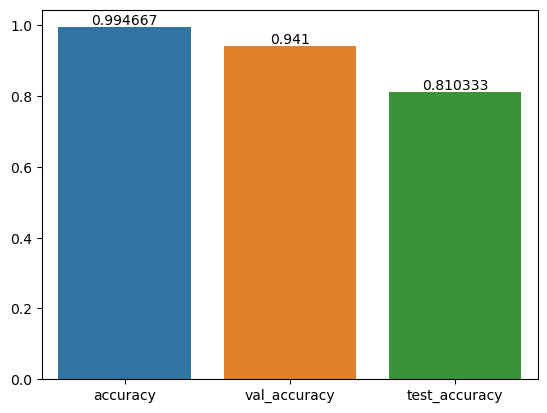

In [53]:
# sns.color_palette("dark:salmon_r", as_cmap=True)

ax = sns.barplot(x=['accuracy', 'val_accuracy', 'test_accuracy'],
            y=[history['accuracy'][-1], history['val_accuracy'][-1], test_accuracy])

ax.bar_label(ax.containers[0])
None

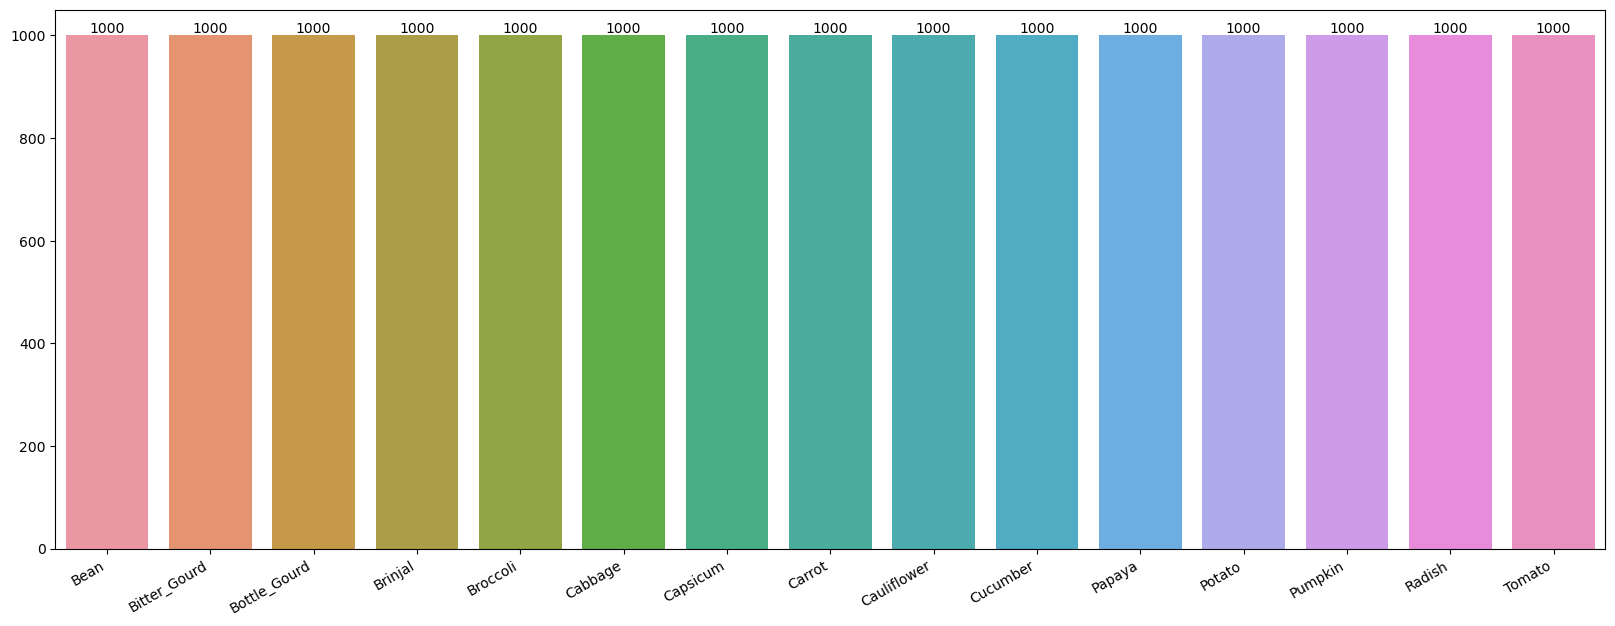

In [54]:
train_veggie_counter = {veggie:len(os.listdir(train_data_dir + '/' + veggie)) for veggie in class_names}

plt.figure(figsize=(20,7))

ax = sns.barplot(y=list(train_veggie_counter.values()),
                 x=list(train_veggie_counter.keys()))

plt.xticks(rotation=30, ha='right')

ax.bar_label(ax.containers[0])
None

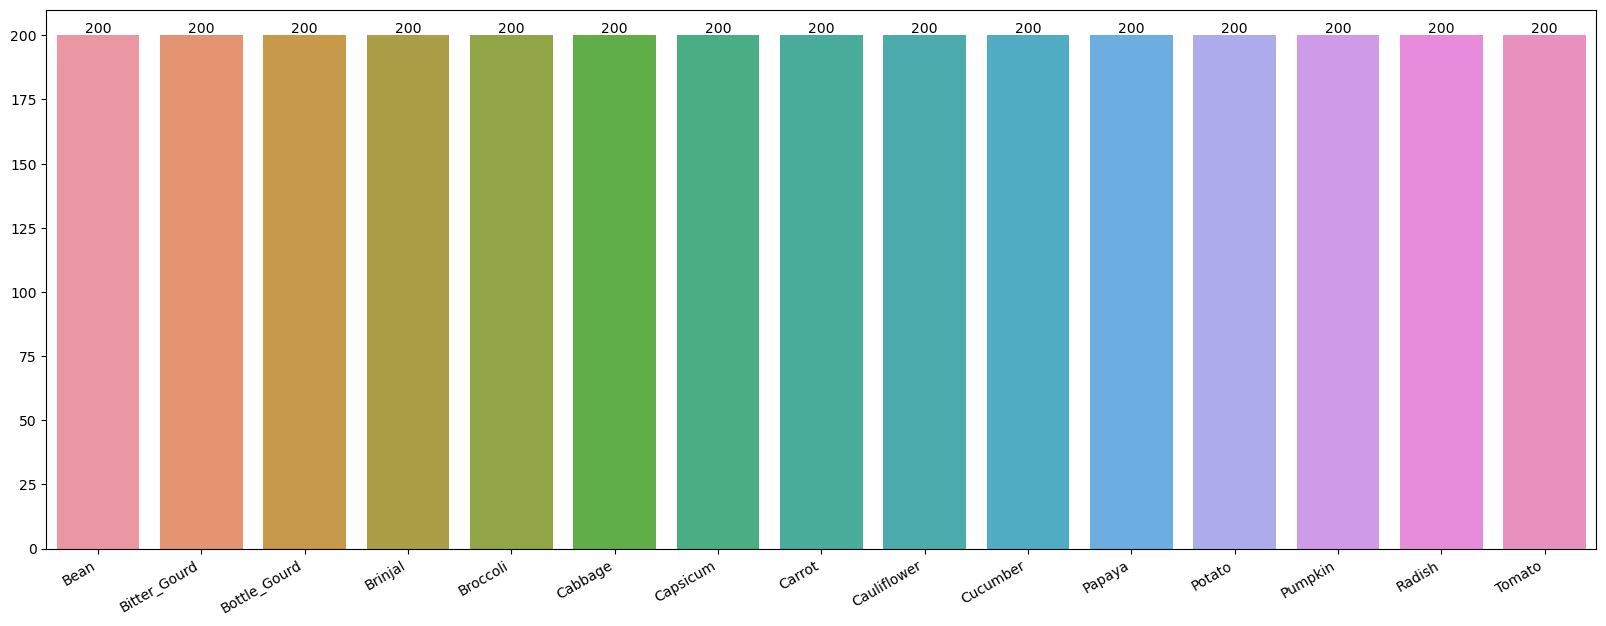

In [55]:
val_veggie_counter = {veggie:len(os.listdir(val_data_dir + '/' + veggie)) for veggie in class_names}

plt.figure(figsize=(20,7))

ax = sns.barplot(y=list(val_veggie_counter.values()),
                 x=list(val_veggie_counter.keys()))

plt.xticks(rotation=30, ha='right')

ax.bar_label(ax.containers[0])
None

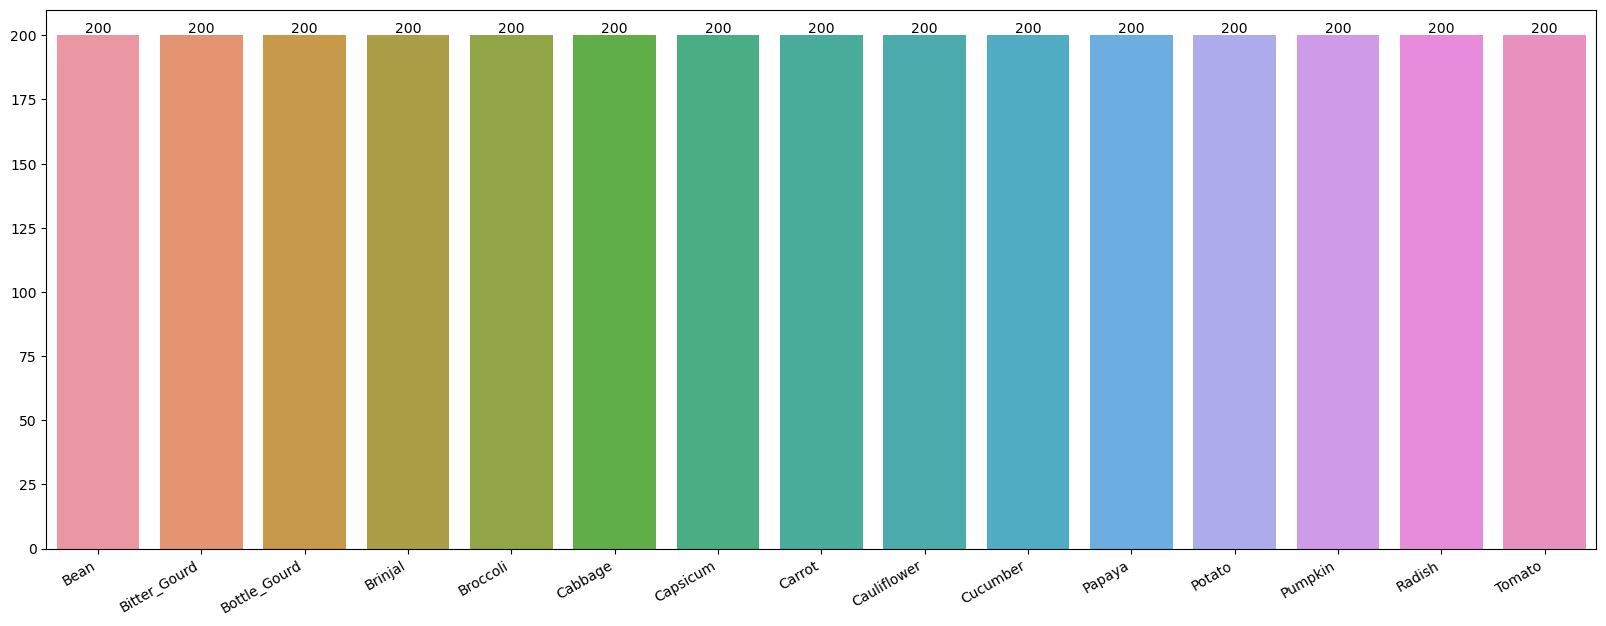

In [56]:
test_veggie_counter = {veggie:len(os.listdir(test_data_dir + '/' + veggie)) for veggie in class_names}

plt.figure(figsize=(20,7))

ax = sns.barplot(y=list(test_veggie_counter.values()),
                 x=list(test_veggie_counter.keys()))

plt.xticks(rotation=30, ha='right')

ax.bar_label(ax.containers[0])
None

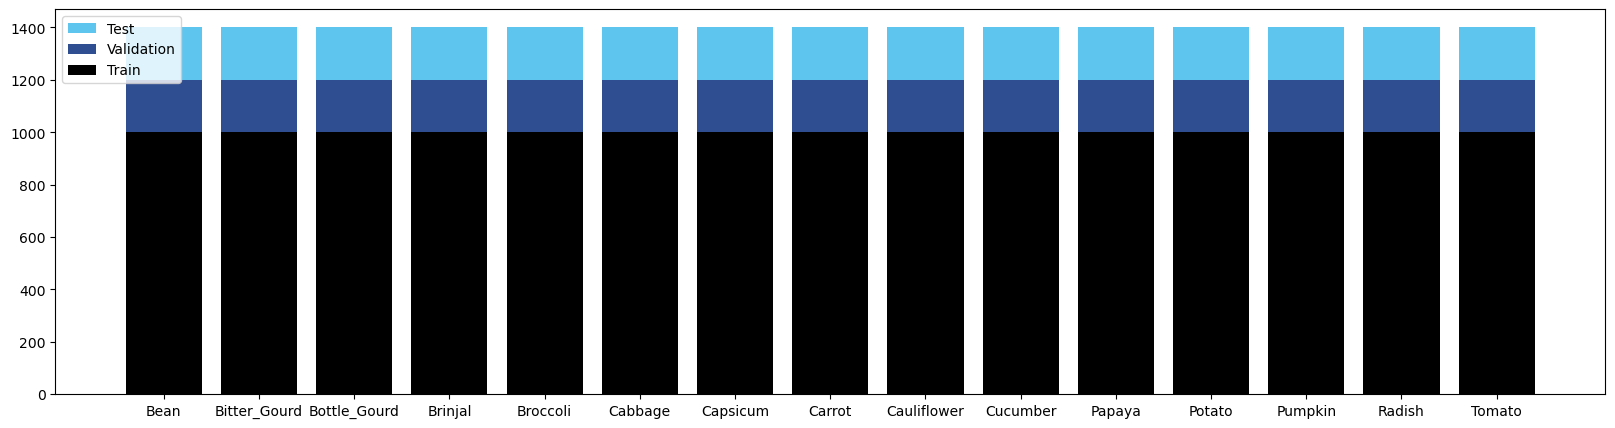

In [96]:
train_veggie_counter = {veggie:len(os.listdir(train_data_dir + '/' + veggie)) for veggie in class_names}
val_veggie_counter = {veggie:len(os.listdir(val_data_dir + '/' + veggie)) for veggie in class_names}
test_veggie_counter = {veggie:len(os.listdir(test_data_dir + '/' + veggie)) for veggie in class_names}

fig, ax = plt.subplots(figsize=(20,5))

ax.bar(x=list(train_veggie_counter.keys()),
       height=list(train_veggie_counter.values()),
       label='Train',
       color='#000000')

ax.bar(x=list(train_veggie_counter.keys()),
       height=list(val_veggie_counter.values()),
       bottom=list(train_veggie_counter.values()),
       label='Validation',
       color='#2F4D91')

ax.bar(x=list(train_veggie_counter.keys()),
       height=list(test_veggie_counter.values()),
       bottom=[v + t for v, t in zip(list(val_veggie_counter.values()), list(train_veggie_counter.values()))],
       label='Test',
       color='#5EC5EF')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
None

# Deployment

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import Input

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd

import os
import cv2

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
img_size = 224

In [9]:
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal',
               'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower',
               'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

In [10]:
model = keras.models.load_model("D:\\data_projects\\veggie_classification\\my_model")

In [11]:
def get_prediction_single_image(model, directory):
    
    try:
        img = tf.keras.preprocessing.image.load_img(directory, target_size=(img_size, img_size, 3))
        plt.imshow(img)
        plt.axis("off")

        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array)
        score = tf.nn.softmax(prediction[0])
        
        print('I predict: ', class_names[np.argmax(score)])
    except:
        print('Thats not an image')
    return

1/1 [==============================] - 0s 62ms/step
I predict:  apple


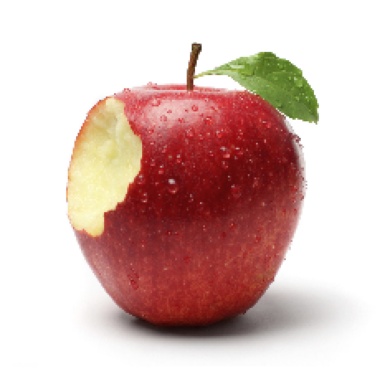

In [78]:
get_prediction_single_image(model, os.path.join(test_data_dir, 'Bean' , 'Bean_0.jpg'))

## Test new data collected from Google

In [19]:
# def get_prediction_single_image_manual(model, directory):
    
#     img = tf.keras.preprocessing.image.load_img(directory, target_size=(img_size, img_size, 3))
#     plt.imshow(img)
#     plt.axis("off")

#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)

#     prediction = model.predict(img_array)
#     score = tf.nn.softmax(prediction[0])

#     print('I predict: ', class_names[np.argmax(score)])

#     return

In [22]:
# test_manual_directory = 'D:\\data_projects\\veggie_classification\\test_manual'

In [97]:
# get_prediction_single_image_manual(model, os.path.join(test_manual_directory, 'apple' , 'apple manual_3.jfif'))

## Demploy

In [ ]:
# import os

# import tensorflow as tf
# from tensorflow import keras

# import numpy as np
# import matplotlib.pyplot as plt

# import streamlit as st
# import requests



# def get_prediction_single_image(model, directory):
    
#     img = tf.keras.preprocessing.image.load_img(directory, target_size=(224, 224, 3))
#     plt.imshow(img)
#     plt.axis("off")

#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)

#     prediction = model.predict(img_array)
#     score = tf.nn.softmax(prediction[0])

#     return class_names[np.argmax(score)]


# class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal',
#                'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower',
#                'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

# model = keras.models.load_model("D:\\data_projects\\veggie_classification\\my_model")


# def get_image(url):
#     img = requests.get(url)
#     file = open('sample_image.jpg', 'wb')
#     file.write(img.content)
#     file.close()
#     img_file_name = 'sample_image.jpg'
#     return img_file_name

# st.title('Vegetable Classification')
# st.write('Add url from the image source')

# url = st.text_input("Enter Image Url:")
# if url:
#     image = get_image(url)
#     st.image(image)
#     classify = st.button("Classify Image")
#     if classify:
#         st.write("")
#         st.write("Classifying...")
#         label = get_prediction_single_image(model, image)
#         st.write(str(label))
# else:
#     st.write("Paste Image URL")

In [35]:
# streamlit run Vegetable_Classification_15_Classes_Deployment.py